In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle'

import shutil
shutil.move('/content/kaggle(5)(1)(4).json', '/root/.kaggle/kaggle.json')

from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate using the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files('ninadaithal/imagesoasis', path='.', unzip=True)


print("Dataset downloaded and extracted!")

Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
Dataset downloaded and extracted!


In [ ]:
import zipfile
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2
from glob import glob

In [ ]:
import os
import shutil
import numpy as np

path_1 = '/content/Data/Mild Dementia'
path_2 = '/content/Data/Moderate Dementia'
path_3 = '/content/Data/Non Demented'
path_4 = '/content/Data/Very mild Dementia'

rootdir = '/content/Data'
train_dir = os.path.join(rootdir, 'train')
test_dir = os.path.join(rootdir, 'test')

np.random.seed(42)

classes = {
    '1': 'Mild Dementia',
    '2': 'Moderate Dementia',
    '3': 'Non Demented',
    '4': 'Very mild Dementia'
}

for class_name in classes.values():
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

def split_and_copy_limited(source_path, class_name, train_dest, test_dest, total_limit=488, test_ratio=0.2):
    all_files = os.listdir(source_path)
    all_files = [f for f in all_files if os.path.isfile(os.path.join(source_path, f))]
    np.random.shuffle(all_files)


    limited_files = all_files[:total_limit]


    split_index = int(len(limited_files) * (1 - test_ratio))
    train_files = limited_files[:split_index]
    test_files = limited_files[split_index:]

    for file in train_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(train_dest, class_name, file))

    for file in test_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(test_dest, class_name, file))

# Apply the function to all classes
split_and_copy_limited(path_1, 'Mild Dementia', train_dir, test_dir)
split_and_copy_limited(path_2, 'Moderate Dementia', train_dir, test_dir)
split_and_copy_limited(path_3, 'Non Demented', train_dir, test_dir)
split_and_copy_limited(path_4, 'Very mild Dementia', train_dir, test_dir)

print("Balanced train-test split (488 images per class) completed successfully!")


Balanced train-test split (488 images per class) completed successfully!


In [ ]:
train_path = '/content/Data/train'
test_path = '/content/Data/test'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest'
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1560 images belonging to 4 classes.
Found 392 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input
from sklearn.metrics import classification_report, confusion_matrix


inputs = Input(shape=(224, 224, 3))

x = Conv2D(16, (3, 3), padding='same', name='conv_initial')(inputs)
x = BatchNormalization(name='bn_initial')(x)
x = Activation('relu', name='relu_initial')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool_initial')(x)

x = Conv2D(32, (3, 3), padding='same', name='conv_block1')(x)
x = BatchNormalization(name='bn_block1')(x)
x = Activation('relu', name='relu_block1')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool_block1')(x)

x = Conv2D(64, (3, 3), padding='same', name='conv_block2')(x)
x = BatchNormalization(name='bn_block2')(x)
x = Activation('relu', name='relu_block2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool_block2')(x)

x = Conv2D(128, (3, 3), padding='same', name='conv_block3')(x)
x = BatchNormalization(name='bn_block3')(x)
x = Activation('relu', name='relu_block3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool_block3')(x)

x = Dropout(0.1, name='dropout_10')(x)

x = Flatten(name='flatten')(x)

x = Dense(256, name='dense_1')(x)
x = BatchNormalization(name='bn_dense')(x)
x = Activation('relu', name='relu_dense')(x)
x = Dropout(0.5, name='dropout_50')(x)

x = Dropout(0.25, name='dropout_25')(x)

num_classes = 4
outputs = Dense(num_classes, activation='softmax', name='output')(x)

model = Model(inputs=inputs, outputs=outputs, name='brain_mri_model')

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_generator, epochs=15, validation_data=test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.2818 - loss: 2.2095 - val_accuracy: 0.2500 - val_loss: 1.6005
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.3746 - loss: 1.5567 - val_accuracy: 0.2500 - val_loss: 2.4278
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.4329 - loss: 1.4304 - val_accuracy: 0.2500 - val_loss: 3.9410
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.4634 - loss: 1.3246 - val_accuracy: 0.2500 - val_loss: 3.0402
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.4775 - loss: 1.3094 - val_accuracy: 0.2500 - val_loss: 5.6407
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - accuracy: 0.4762 - loss: 1.2066 - val_accuracy: 0.3112 - val_loss: 2.4374
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.5314 - loss: 1.1623 - val_accuracy: 0.3495 - val_loss: 1.5788
Epoch 8/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.5069 - loss: 1.1500 - val_accuracy: 0.3342 - v

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - accuracy: 0.4557 - loss: 1.1415
Test Loss: 1.1229102611541748
Test Accuracy: 0.4872449040412903


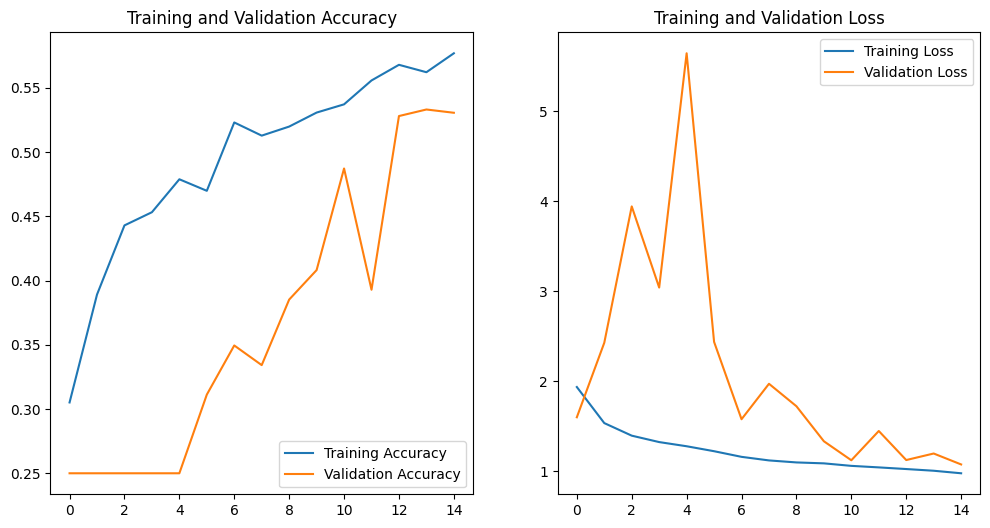

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def plot_confusion_matrix(test_generator, model):

    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)


    cm = confusion_matrix(y_true, y_pred)
    class_names = list(test_generator.class_indices.keys())


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_training_history(history)

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


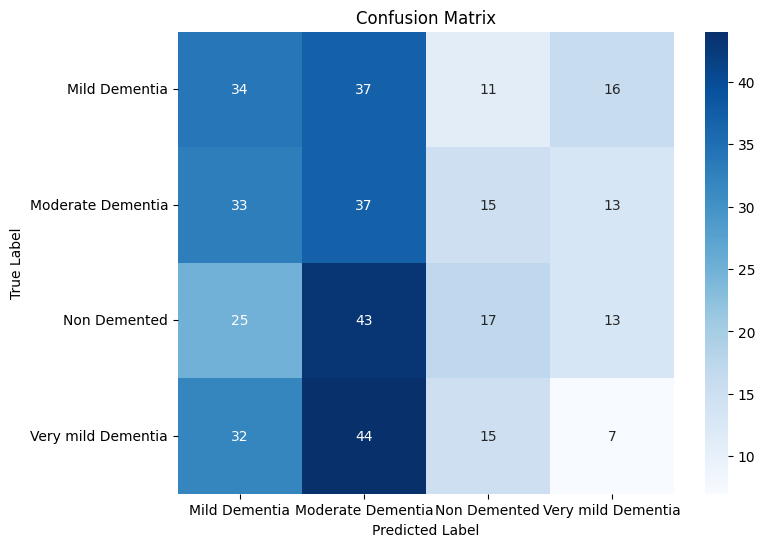

In [ ]:
plot_confusion_matrix(test_generator, model)

In [ ]:
pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=dca8b66873a09180d79232a942c4cddd0375e72d67c897687ddab8b495df138a
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_25']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


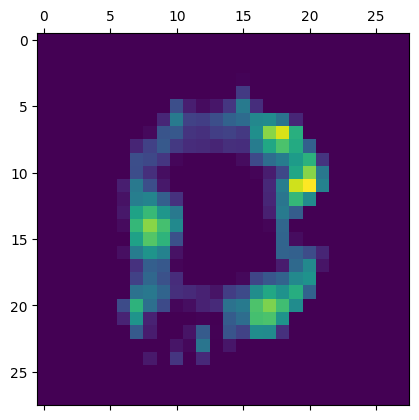

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img = next(train_generator)[0][0]
img_array = np.expand_dims(img, axis=0)

last_conv_layer_name = 'conv_block3'
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

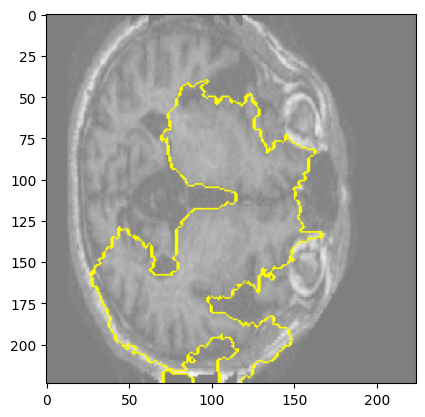

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

def preprocess_for_model(images):

    return images

def predict_fn(images):
    processed = preprocess_for_model(images)
    return model.predict(processed)

img = next(train_generator)[0][0]

explanation = explainer.explain_instance(
    img,
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

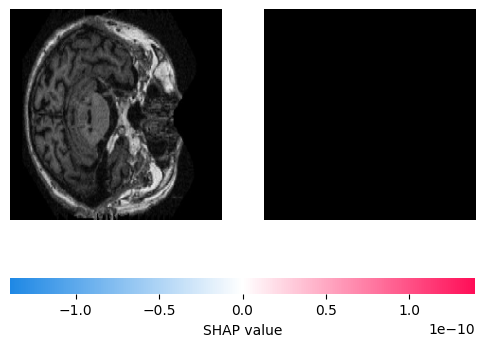

In [ ]:
import shap
import numpy as np


background = next(train_generator)[0][0:100]
explainer = shap.DeepExplainer(model, background)


sample = next(train_generator)[0][0:1]
shap_values = explainer.shap_values(sample)

shap.image_plot(shap_values, sample, show=False)
plt.show()

Found 1560 images belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━

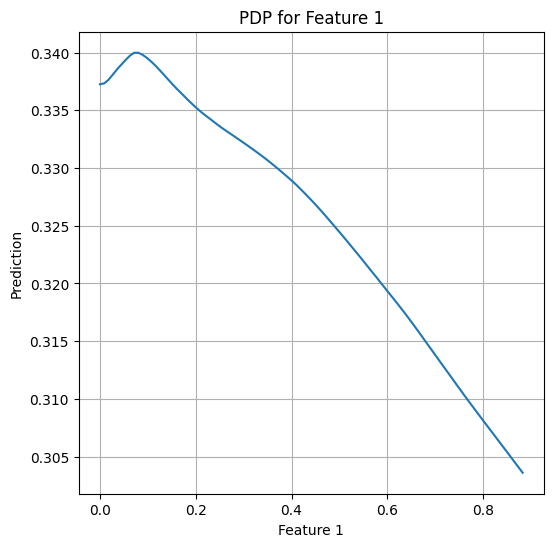

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


X_batch, y_batch = next(train_generator)

feature_idx = 0
feature_name = 'Feature 1'

def plot_pdp_manual(model, generator, feature_idx, feature_name=None, n_samples=32):

    scaler = MinMaxScaler()

    X_batch, _ = next(generator)

    feature_values = np.linspace(X_batch[:, feature_idx].min(), X_batch[:, feature_idx].max(), 100)

    pdp_values = []

    for value in feature_values:

        X_copy = X_batch.copy()


        X_copy[:, feature_idx] = value

        predictions = model.predict(X_copy)

        pdp_values.append(np.mean(predictions, axis=0))

    pdp_values = np.array(pdp_values)

    plt.figure(figsize=(6, 6))
    plt.plot(feature_values, pdp_values[:, 0], label='PDP')
    plt.title(f'PDP for {feature_name or f"Feature {feature_idx}"}')
    plt.xlabel(feature_name or f'Feature {feature_idx}')
    plt.ylabel('Prediction')
    plt.grid(True)
    plt.show()

plot_pdp_manual(model, train_generator, feature_idx, feature_name)
